In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression, SelectKBest,f_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

sns.set_palette(['#b2182b','#ef8a62','#fddbc7','#f7f7f7','#d1e5f0','#67a9cf','#2166ac'])
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [315]:
data2 = pd.read_excel('Storage2.xlsx', sheet_name='Systems')

In [270]:
data = pd.read_csv('History2.csv')

In [271]:
data = data.drop(['ID'], axis = 1)
data = data.drop(['DATE'], axis = 1)
data = data.drop(['SYSTEM_id'], axis = 1)
data2 = data2.drop(['ID'], axis = 1)
data2 = data2.drop(['Name'], axis = 1)
data2 = data2.drop(['Description'], axis = 1)
print(data.info())
print(data2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   SIZE             50 non-null     int64
 1   LOAD_TPD         50 non-null     int64
 2   ACCOUNTS_ALL     50 non-null     int64
 3   ACCOUNTS_ACTIVE  50 non-null     int64
 4   Non_kept_size    50 non-null     int64
 5   Backup_size      50 non-null     int64
 6   LongOps_min      50 non-null     int64
dtypes: int64(7)
memory usage: 2.9 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Stage                       18 non-null     object
 1   Type                        18 non-null     object
 2   Size, Gb                    18 non-null     int64 
 3   Data Keep, years            18 non-null     int64 
 4   Backup retention

2. Feature Engineering

In [272]:
data['Active_All'] = data['ACCOUNTS_ACTIVE'] / data['ACCOUNTS_ALL']
print(data[['ACCOUNTS_ACTIVE', 'ACCOUNTS_ALL', 'Active_All']].head())

   ACCOUNTS_ACTIVE  ACCOUNTS_ALL  Active_All
0           495005        520000        0.95
1           515780        540000        0.96
2           536555        560000        0.96
3           567331        580000        0.98
4           603106        650000        0.93


In [273]:
data['Backup_Efficiency'] = data['Backup_size'] / data['SIZE']
print(data[[ 'SIZE', 'Backup_size', 'Backup_Efficiency']].head())

   SIZE  Backup_size  Backup_Efficiency
0  4100         3280               0.80
1  4180         3340               0.80
2  4270         3410               0.80
3  4350         3480               0.80
4  4440         3550               0.80


In [274]:
data['Kept_size'] = data['SIZE'] - data['Non_kept_size']
print(data[['SIZE', 'Non_kept_size', 'Kept_size']].head())

   SIZE  Non_kept_size  Kept_size
0  4100            116       3984
1  4180            121       4059
2  4270            125       4145
3  4350            130       4220
4  4440            140       4300


3. Data Normalization and Encoding

In [275]:
columns_to_normalize = ['LOAD_TPD', 'ACCOUNTS_ALL', 
                        'ACCOUNTS_ACTIVE', 'Active_All', 
                        'Non_kept_size', 'Kept_size', 'Backup_size', 
                        'Backup_Efficiency', 'LongOps_min']

Min-Max Scaling

In [276]:
data_norm_minmax = data.copy()

In [277]:
scaler = MinMaxScaler()
data_norm_minmax[columns_to_normalize] = scaler.fit_transform(data_norm_minmax[columns_to_normalize])

In [278]:
data_norm_minmax.head()

,SIZE,LOAD_TPD,ACCOUNTS_ALL,ACCOUNTS_ACTIVE,Non_kept_size,Backup_size,LongOps_min,Active_All,Backup_Efficiency,Kept_size
0,4100,0.00,0.00,0.00,0.26,0.00,0.99,0.48,1.00,0.00
1,4180,0.01,0.01,0.01,0.29,0.03,0.99,0.51,0.99,0.02
2,4270,0.01,0.02,0.02,0.31,0.06,0.98,0.55,0.99,0.04
3,4350,0.02,0.03,0.03,0.34,0.09,0.99,0.76,1.00,0.06
4,4440,0.00,0.06,0.05,0.40,0.13,0.99,0.22,0.99,0.08


Standardization (Z-score Normalization)

In [279]:
data_norm_stand = data.copy()

In [280]:
scaler1 = StandardScaler()
data_norm_stand[columns_to_normalize] = scaler1.fit_transform(data_norm_stand[columns_to_normalize])

In [281]:
data_norm_stand.head()

,SIZE,LOAD_TPD,ACCOUNTS_ALL,ACCOUNTS_ACTIVE,Non_kept_size,Backup_size,LongOps_min,Active_All,Backup_Efficiency,Kept_size
0,4100,-1.18,-1.46,-1.41,-0.52,-2.12,0.87,-0.56,0.90,-1.64
1,4180,-1.16,-1.43,-1.38,-0.43,-2.01,0.88,-0.46,0.89,-1.58
2,4270,-1.13,-1.40,-1.35,-0.35,-1.88,0.86,-0.36,0.88,-1.51
3,4350,-1.09,-1.37,-1.31,-0.26,-1.75,0.88,0.29,0.90,-1.45
4,4440,-1.18,-1.27,-1.26,-0.07,-1.62,0.87,-1.35,0.89,-1.39


Categorical data encoding

One-Hot Encoding

In [282]:
data2_encoded = data2.copy()

In [283]:
data2_encoded = pd.get_dummies(data2_encoded, columns=['Stage', 'Type', 'Data Keep, years', 'Backup retention, month', 'Depreciation period, years', 'Data retention, years'])

In [284]:
data2_encoded.head()

,"Size, Gb",Stage_Arch,Stage_Bkp,Stage_Dev,Stage_Prod,Stage_Stage,Stage_Stby,Stage_Test,Type_Bkp,Type_DWH,Type_Mixed,Type_OLTP,"Data Keep, years_2","Data Keep, years_20","Backup retention, month_0","Backup retention, month_1","Depreciation period, years_0","Depreciation period, years_5","Depreciation period, years_7","Data retention, years_0","Data retention, years_7","Data retention, years_20"
0,8000,False,False,False,True,False,False,False,False,False,True,False,True,False,False,True,False,True,False,False,True,False
1,8000,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False,True,False,False,True,False,False
2,8000,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,True,False,False,True,False,False
3,8000,False,False,False,False,False,False,True,False,False,True,False,True,False,True,False,True,False,False,True,False,False
4,8000,False,False,True,False,False,False,False,False,False,True,False,True,False,True,False,True,False,False,True,False,False


4. Correlation Analysis

In [285]:
data.corr()

,SIZE,LOAD_TPD,ACCOUNTS_ALL,ACCOUNTS_ACTIVE,Non_kept_size,Backup_size,LongOps_min,Active_All,Backup_Efficiency,Kept_size
SIZE,1.00,0.95,0.99,0.99,-0.39,0.89,-0.87,0.83,-0.86,1.00
LOAD_TPD,0.95,1.00,0.97,0.97,-0.49,0.78,-0.91,0.78,-0.87,0.96
ACCOUNTS_ALL,0.99,0.97,1.00,1.00,-0.43,0.86,-0.89,0.83,-0.88,1.00
ACCOUNTS_ACTIVE,0.99,0.97,1.00,1.00,-0.44,0.85,-0.89,0.84,-0.88,0.99
Non_kept_size,-0.39,-0.49,-0.43,-0.44,1.00,0.08,0.66,-0.46,0.79,-0.42
Backup_size,0.89,0.78,0.86,0.85,0.08,1.00,-0.61,0.67,-0.54,0.87
LongOps_min,-0.87,-0.91,-0.89,-0.89,0.66,-0.61,1.00,-0.75,0.92,-0.88
Active_All,0.83,0.78,0.83,0.84,-0.46,0.67,-0.75,1.00,-0.81,0.84
Backup_Efficiency,-0.86,-0.87,-0.88,-0.88,0.79,-0.54,0.92,-0.81,1.00,-0.88
Kept_size,1.00,0.96,1.00,0.99,-0.42,0.87,-0.88,0.84,-0.88,1.00


In [286]:
correlation = data.corr()['SIZE'].sort_values(ascending=False)
correlation

SIZE                 1.00
Kept_size            1.00
ACCOUNTS_ALL         0.99
ACCOUNTS_ACTIVE      0.99
LOAD_TPD             0.95
Backup_size          0.89
Active_All           0.83
Non_kept_size       -0.39
Backup_Efficiency   -0.86
LongOps_min         -0.87
Name: SIZE, dtype: float64

In [287]:
correlation = data2_encoded.corr()['Size, Gb'].sort_values(ascending=False)
correlation

Size, Gb                        1.00
Stage_Arch                      0.65
Depreciation period, years_7    0.54
Type_Bkp                        0.54
Data retention, years_7         0.47
Backup retention, month_1       0.41
Data Keep, years_2              0.04
Type_DWH                        0.04
Stage_Bkp                       0.03
Data Keep, years_20            -0.04
Data retention, years_20       -0.07
Depreciation period, years_5   -0.13
Stage_Prod                     -0.13
Stage_Dev                      -0.13
Stage_Stby                     -0.17
Stage_Stage                    -0.17
Stage_Test                     -0.17
Type_Mixed                     -0.18
Backup retention, month_0      -0.41
Depreciation period, years_0   -0.41
Data retention, years_0        -0.41
Type_OLTP                      -0.42
Name: Size, Gb, dtype: float64

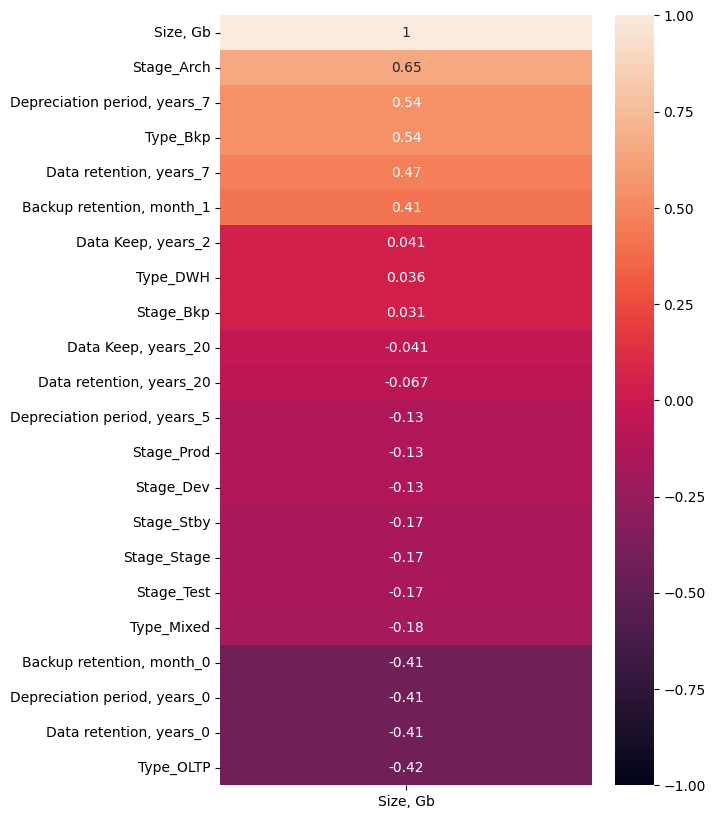

In [288]:
plt.figure(figsize=(6, 10))
sns.heatmap(correlation.to_frame(), annot = True, vmin = -1, vmax = 1, cbar=True)
plt.show()

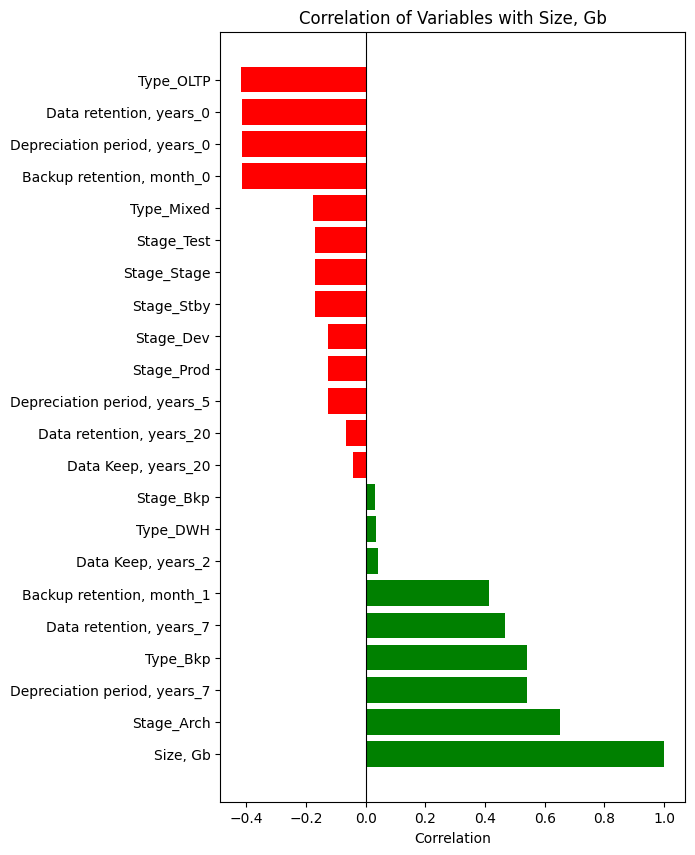

In [289]:
plt.figure(figsize=(6, 10))
colors = ['red' if c < 0 else 'green' for c in correlation.values]
plt.barh(correlation.index, correlation.values, color=colors)
plt.axvline(x=0, color='black', linewidth=0.8)
plt.xlabel('Correlation')
plt.title('Correlation of Variables with Size, Gb')
plt.show()

5. Feature Importance Analysis

These are statistical methods used for univariate feature selection. They evaluate each feature individually with the target variable to select the most informative features. SelectKBest selects the top k features based on a chosen metric (e.g., F-test, mutual information), while Mutual Information measures the dependency between features and the target.

Mutual Information (Filter Method)

For Numerical Variables:
Mutual Information is not sensitive to feature scaling. It measures statistical dependence between variables. Thus, using the original, normalized, or standardized data should not significantly affect its performance.


Mutual information measures the dependency between two variables. In the context of feature selection, it measures the dependency between each feature and the target variable.

In [290]:
y = data['SIZE']
X = data_norm_stand.drop('SIZE', axis=1)
mutual_info = mutual_info_regression(X, y)
mi_scores = pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mutual_info})
mi_scores = mi_scores.sort_values(by='Mutual_Information', ascending=False)
mi_scores

,Feature,Mutual_Information
8,Kept_size,2.51
1,ACCOUNTS_ALL,2.43
2,ACCOUNTS_ACTIVE,2.38
3,Non_kept_size,2.20
0,LOAD_TPD,1.78
4,Backup_size,1.63
6,Active_All,1.01
5,LongOps_min,0.91
7,Backup_Efficiency,0.68


In summary, features with higher Mutual Information scores are more influential in predicting 'System Size', whereas those with lower scores might have less predictive power. These scores help prioritize features based on their relationship strength with the target variable, aiding in feature selection for your predictive model.

Mutual information for categorical

In [291]:
y = data2_encoded['Size, Gb']
X = data2_encoded.drop('Size, Gb', axis=1)
mutual_info = mutual_info_regression(X, y)
mi_scores = pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mutual_info})
mi_scores = mi_scores.sort_values(by='Mutual_Information', ascending=False)
mi_scores

,Feature,Mutual_Information
10,Type_OLTP,0.57
9,Type_Mixed,0.32
7,Type_Bkp,0.22
8,Type_DWH,0.17
18,"Data retention, years_0",0.15
15,"Depreciation period, years_0",0.15
13,"Backup retention, month_0",0.13
14,"Backup retention, month_1",0.12
12,"Data Keep, years_20",0.11
19,"Data retention, years_7",0.10


SelectKBest (Filter Method)

Univariate Feature Selection methods, such as SelectKBest, often assume standard normally distributed data, so using standardized data might be more appropriate.

In [292]:
num_features = 5
selector = SelectKBest(score_func=f_regression, k=num_features)
y = data['SIZE']
X = data_norm_stand.drop('SIZE', axis=1)
X_selected = selector.fit_transform(X, y)
selected_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_indices]
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['LOAD_TPD', 'ACCOUNTS_ALL', 'ACCOUNTS_ACTIVE', 'Backup_size',
       'Kept_size'],
      dtype='object')


SelectKBest for categorical data

In [293]:
num_features = 5 

y = data2_encoded['Size, Gb']
X = data2_encoded.drop('Size, Gb', axis=1)

selector = SelectKBest(score_func=f_regression, k=num_features)
X_selected = selector.fit_transform(X, y)
selected_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_indices]
selected_features

Index(['Stage_Arch', 'Type_Bkp', 'Type_OLTP', 'Depreciation period, years_7',
       'Data retention, years_7'],
      dtype='object')

ANOVA F-test (Filter method) on categorical data:

In [294]:
y = data2_encoded['Size, Gb']
X = data2_encoded.drop('Size, Gb', axis=1)
f_values, p_values = f_regression(X, y)
anova_scores = pd.DataFrame({'Feature': X.columns, 'F_Value': f_values, 'P_Value': p_values})
anova_scores = anova_scores.sort_values(by='F_Value', ascending=False)
anova_scores

,Feature,F_Value,P_Value
0,Stage_Arch,11.86,0.00
7,Type_Bkp,6.60,0.02
17,"Depreciation period, years_7",6.60,0.02
19,"Data retention, years_7",4.49,0.05
10,Type_OLTP,3.37,0.08
13,"Backup retention, month_0",3.32,0.09
15,"Depreciation period, years_0",3.32,0.09
18,"Data retention, years_0",3.32,0.09
14,"Backup retention, month_1",3.32,0.09
9,Type_Mixed,0.52,0.48


Wrapper Method:

Recursive Feature Elimination (RFE)

 It works by recursively fitting the model and eliminating the least significant features based on their importance ranking until the desired number of features is reached. It's generally used in combination with models that provide feature importance (like Linear Regression, Random Forest, etc.).

In [295]:
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=num_features)

y = data['SIZE']
X = data_norm_stand.drop('SIZE', axis=1)

selector = selector.fit(X, y)
selected_features = X.columns[selector.support_]
selected_features

Index(['ACCOUNTS_ALL', 'Non_kept_size', 'Backup_size', 'Backup_Efficiency',
       'Kept_size'],
      dtype='object')

Recursive Feature Elimination (RFE) for categorical data:

In [296]:
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=num_features)

y = data2_encoded['Size, Gb']
X = data2_encoded.drop('Size, Gb', axis=1)

selector = selector.fit(X, y)
selected_features = X.columns[selector.support_]
selected_features

Index(['Stage_Arch', 'Type_DWH', 'Type_Mixed', 'Type_OLTP',
       'Data Keep, years_2'],
      dtype='object')

Random Forest Feature Importance (Tree-based method)

Feature Importance from Random Forest can be influenced by the scale of numerical features. Random Forests are not sensitive to feature scaling, but for interpretability purposes, using standardized data might be preferred. Standardization could lead to features having equal weight and better interpretability in this context.

Random Forests can measure feature importance by analyzing how much each feature contributes to decreasing impurity (Gini/entropy) in decision trees within the forest.

In [297]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
y = data_norm_stand['SIZE']
X = data_norm_stand.drop('SIZE', axis=1)
rf.fit(X, y)
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

             Feature  Importance
1       ACCOUNTS_ALL        0.27
0           LOAD_TPD        0.23
2    ACCOUNTS_ACTIVE        0.18
8          Kept_size        0.15
6         Active_All        0.04
7  Backup_Efficiency        0.04
3      Non_kept_size        0.03
5        LongOps_min        0.03
4        Backup_size        0.02


Random Forest for categoricals

In [298]:
y = data2_encoded['Size, Gb']
X = data2_encoded.drop('Size, Gb', axis=1)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

                         Feature  Importance
0                     Stage_Arch        0.55
10                     Type_OLTP        0.18
19       Data retention, years_7        0.07
7                       Type_Bkp        0.04
1                      Stage_Bkp        0.04
8                       Type_DWH        0.03
17  Depreciation period, years_7        0.03
9                     Type_Mixed        0.03
11            Data Keep, years_2        0.01
3                     Stage_Prod        0.01
20      Data retention, years_20        0.01
16  Depreciation period, years_5        0.01
13     Backup retention, month_0        0.00
12           Data Keep, years_20        0.00
14     Backup retention, month_1        0.00
15  Depreciation period, years_0        0.00
18       Data retention, years_0        0.00
6                     Stage_Test        0.00
5                     Stage_Stby        0.00
4                    Stage_Stage        0.00
2                      Stage_Dev        0.00


Lasso, Ridge, and Elastic Net:

These are regularization techniques commonly used in linear models. They introduce penalties to the model's coefficients during training, which encourages sparsity by shrinking or eliminating the coefficients of less important features. They perform feature selection as a part of their learning process.

Lasso (L1 regularization) penalizes the absolute size of coefficients, effectively performing feature selection by shrinking some coefficients to zero. This can help identify important features.

Ridge (L2 regularization) penalizes the squared size of coefficients, limiting their overall size, but rarely setting them to zero. It's helpful when you believe most of your features are relevant.

Elastic Net combines both L1 and L2 regularization. It works well when you have a large number of features and some of them are correlated.

Initialize and fit Lasso with original data

In [299]:
y = data['SIZE']
X = data.drop('SIZE', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

In [300]:
lasso = Lasso(alpha=0.5)  
lasso.fit(X_train, y_train)

lasso_coefficients = lasso.coef_
feature_names = X.columns.tolist()
feature_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': lasso_coefficients})
dropped_features = feature_coefficients[feature_coefficients['Coefficient'] == 0]['Feature']
kept_features = feature_coefficients[feature_coefficients['Coefficient'] != 0]['Feature']

scores = cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
rmse_scores = -scores

print("Mean RMSE:", rmse_scores.mean())
print("Standard Deviation of RMSE:", rmse_scores.std())

print("\nDropped Features:")
print(dropped_features)

print("\nKept Features:")
print(kept_features)

Mean RMSE: 24.451901252388588
Standard Deviation of RMSE: 9.480103508120399

Dropped Features:
6           Active_All
7    Backup_Efficiency
Name: Feature, dtype: object

Kept Features:
0           LOAD_TPD
1       ACCOUNTS_ALL
2    ACCOUNTS_ACTIVE
3      Non_kept_size
4        Backup_size
5        LongOps_min
8          Kept_size
Name: Feature, dtype: object


Initialize and fit Lasso with standardized data

In [301]:
ys = data_norm_stand['SIZE']
Xs = data_norm_stand.drop('SIZE', axis=1)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.2, random_state=55)

In [302]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.2, random_state=55)

In [303]:
lasso = Lasso(alpha=0.5)  
lasso.fit(Xs_train, ys_train)

lasso_coefficients = lasso.coef_
feature_names = Xs.columns.tolist()
feature_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': lasso_coefficients})
dropped_features = feature_coefficients[feature_coefficients['Coefficient'] == 0]['Feature']
kept_features = feature_coefficients[feature_coefficients['Coefficient'] != 0]['Feature']

scores = cross_val_score(lasso, Xs_train, ys_train, cv=5, scoring='neg_root_mean_squared_error')
rmse_scores = -scores

print("Mean MSE:", rmse_scores.mean())
print("Standard Deviation of MSE:", rmse_scores.std())

print("\nDropped Features:")
print(dropped_features)

print("\nKept Features:")
print(kept_features)

Mean MSE: 10.774807017712543
Standard Deviation of MSE: 4.382960914492141

Dropped Features:
2    ACCOUNTS_ACTIVE
5        LongOps_min
Name: Feature, dtype: object

Kept Features:
0             LOAD_TPD
1         ACCOUNTS_ALL
3        Non_kept_size
4          Backup_size
6           Active_All
7    Backup_Efficiency
8            Kept_size
Name: Feature, dtype: object


Initialize and fit Ridge

In [304]:
pd.set_option('display.float_format', lambda x: '%.10f' % x)

In [305]:
ridge = Ridge(alpha=0.5, random_state=55)  
ridge.fit(X_train, y_train)

ridge_coefficients = ridge.coef_
ridge_intercept = ridge.intercept_

feature_names = Xs.columns.tolist()
feature_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': ridge_coefficients})

scores = cross_val_score(ridge, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
rmse_scores = -scores

print("Mean RMSE:", rmse_scores.mean())
print("Standard Deviation of RMSE:", rmse_scores.std())


print("\nRidge Coefficients:")
feature_coefficients = feature_coefficients.sort_values(by='Coefficient', ascending=False)
print(feature_coefficients)

print("\nRidge Intercept:")
print(ridge_intercept)


Mean RMSE: 0.016868618076120584
Standard Deviation of RMSE: 0.007866987256212363

Ridge Coefficients:
             Feature   Coefficient
8          Kept_size  0.9994456656
3      Non_kept_size  0.9949121455
4        Backup_size  0.0008910016
5        LongOps_min  0.0000423301
1       ACCOUNTS_ALL  0.0000003031
0           LOAD_TPD -0.0000000016
2    ACCOUNTS_ACTIVE -0.0000000605
6         Active_All -0.0001913706
7  Backup_Efficiency -0.0003334751

Ridge Intercept:
-0.249002596920036


Initialize and fit Elastic Net

In [306]:
elastic_net = ElasticNetCV(cv=5, random_state=55)
elastic_net.fit(X_train, y_train)

scores = cross_val_score(elastic_net, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
rmse_scores = -scores

print("Mean RMSE:", rmse_scores.mean())
print("Standard Deviation of RMSE:", rmse_scores.std())

print("\nElastic Net Alpha (Regularization Parameter):", elastic_net.alpha_)
print("Elastic Net L1 Ratio (Mixing Parameter):", elastic_net.l1_ratio_)
print("Elastic Net Coefficients:")
elastic_net_coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': elastic_net.coef_})
elastic_net_coefficients = elastic_net_coefficients.sort_values(by='Coefficient', ascending=False)
print(elastic_net_coefficients)
print("Elastic Net Intercept:", elastic_net.intercept_)


Mean RMSE: 124.00440267745985
Standard Deviation of RMSE: 25.968418499514115

Elastic Net Alpha (Regularization Parameter): 16580600.000000002
Elastic Net L1 Ratio (Mixing Parameter): 0.5
Elastic Net Coefficients:
             Feature   Coefficient
1       ACCOUNTS_ALL  0.0014149449
2    ACCOUNTS_ACTIVE  0.0003410720
3      Non_kept_size  0.0000000000
4        Backup_size  0.0000000000
5        LongOps_min  0.0000000000
6         Active_All  0.0000000000
7  Backup_Efficiency -0.0000000000
8          Kept_size  0.0000000000
0           LOAD_TPD -0.0000053243
Elastic Net Intercept: 3598.2722311385273


Categorical Data

Lasso:

In [307]:
yc = data2['Size, Gb']
Xc = data2_encoded.drop('Size, Gb', axis=1)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=66)


In [308]:
lasso = Lasso(alpha=0.5, random_state=66)  
lasso.fit(Xc_train, yc_train)

lasso_coefficients = lasso.coef_
feature_names = Xc.columns.tolist()
feature_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': lasso_coefficients})
dropped_features = feature_coefficients[feature_coefficients['Coefficient'] == 0]['Feature']
kept_features = feature_coefficients[feature_coefficients['Coefficient'] != 0]['Feature']

scores = cross_val_score(lasso, Xc_train, yc_train, cv=5, scoring='neg_root_mean_squared_error')
rmse_scores = -scores

print("Mean MSE:", rmse_scores.mean())
print("Standard Deviation of MSE:", rmse_scores.std())

print("\nDropped Features:")
print(dropped_features)

print("\nKept Features:")
print(kept_features)

Mean MSE: 6817.485376751048
Standard Deviation of MSE: 7327.548383815023

Dropped Features:
2                        Stage_Dev
3                       Stage_Prod
4                      Stage_Stage
5                       Stage_Stby
6                       Stage_Test
9                       Type_Mixed
11              Data Keep, years_2
12             Data Keep, years_20
13       Backup retention, month_0
14       Backup retention, month_1
15    Depreciation period, years_0
16    Depreciation period, years_5
17    Depreciation period, years_7
18         Data retention, years_0
19         Data retention, years_7
20        Data retention, years_20
Name: Feature, dtype: object

Kept Features:
0     Stage_Arch
1      Stage_Bkp
7       Type_Bkp
8       Type_DWH
10     Type_OLTP
Name: Feature, dtype: object


Ridge for categorical

In [309]:
ridge = Ridge(alpha=0.05, random_state=66)  
ridge.fit(Xc_train, yc_train)

ridge_coefficients = ridge.coef_
ridge_intercept = ridge.intercept_

# Create a DataFrame to map feature names to their coefficients
feature_names = Xc.columns.tolist()
feature_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': ridge_coefficients})

scores = cross_val_score(lasso, Xc_train, yc_train, cv=5, scoring='neg_root_mean_squared_error')
rmse_scores = -scores

print("Mean MSE:", rmse_scores.mean())
print("Standard Deviation of MSE:", rmse_scores.std())


print("\nRidge Coefficients:")
feature_coefficients = feature_coefficients.sort_values(by='Coefficient', ascending=False)
print(feature_coefficients)

print("\nRidge Intercept:")
print(ridge_intercept)

Mean MSE: 6817.485376751048
Standard Deviation of MSE: 7327.548383815023

Ridge Coefficients:
                         Feature      Coefficient
0                     Stage_Arch 12594.6849967063
7                       Type_Bkp  4213.7602373151
17  Depreciation period, years_7  4213.7602373151
14     Backup retention, month_1  1255.1195913948
12           Data Keep, years_20  1100.1085432288
8                       Type_DWH  1100.1085432288
19       Data retention, years_7   665.2913719787
20      Data retention, years_20   589.8282194161
2                      Stage_Dev  -302.9973120649
6                     Stage_Test  -312.4129521132
4                    Stage_Stage  -312.4129521132
5                     Stage_Stby  -327.2963751036
9                     Type_Mixed  -680.3723082147
11            Data Keep, years_2 -1100.1085432288
13     Backup retention, month_0 -1255.1195913948
15  Depreciation period, years_0 -1255.1195913948
18       Data retention, years_0 -1255.1195913948
16  De

Elastic Net for categorical

In [310]:
elastic_net = ElasticNetCV(cv=5, random_state=66)
elastic_net.fit(Xc_train, yc_train)

scores = cross_val_score(lasso, Xc_train, yc_train, cv=5, scoring='neg_root_mean_squared_error')
rmse_scores = -scores

print("Mean MSE:", rmse_scores.mean())
print("Standard Deviation of MSE:", rmse_scores.std())

print("\nElastic Net Alpha (Regularization Parameter):", elastic_net.alpha_)
print("Elastic Net L1 Ratio (Mixing Parameter):", elastic_net.l1_ratio_)
print("Elastic Net Coefficients:")
elastic_net_coefficients = pd.DataFrame({'Feature': Xc.columns, 'Coefficient': elastic_net.coef_})
elastic_net_coefficients = elastic_net_coefficients.sort_values(by='Coefficient', ascending=False)
print(elastic_net_coefficients)
print("Elastic Net Intercept:", elastic_net.intercept_)

Mean MSE: 6817.485376751048
Standard Deviation of MSE: 7327.548383815023

Elastic Net Alpha (Regularization Parameter): 7.530612244897959
Elastic Net L1 Ratio (Mixing Parameter): 0.5
Elastic Net Coefficients:
                         Feature     Coefficient
0                     Stage_Arch  774.0558335898
17  Depreciation period, years_7  763.1431167275
7                       Type_Bkp  763.1412498281
19       Data retention, years_7  520.8467898273
14     Backup retention, month_1  515.0209745790
12           Data Keep, years_20   18.6116042777
8                       Type_DWH   18.6110636789
20      Data retention, years_20   -4.8286584799
1                      Stage_Bkp   -9.9182388967
11            Data Keep, years_2  -18.6115932734
2                      Stage_Dev  -87.3249885761
5                     Stage_Stby -112.2918822783
6                     Stage_Test -156.1987989489
4                    Stage_Stage -156.1989908951
9                     Type_Mixed -175.7691555506
16  Dep

In [311]:
data_num_ch = {
    'Feature': ['ACCOUNTS_ACTIVE', 'ACCOUNTS_ALL', 'LOAD_TPD', 
                'Non_kept_size', 'Backup_size', 'Kept_size', 
                'Active_All', 'Backup_Efficiency', 'LongOps_min'],
    'Selected': [6, 8, 6, 
                 5, 6, 6, 
                 2, 3, 2]
}

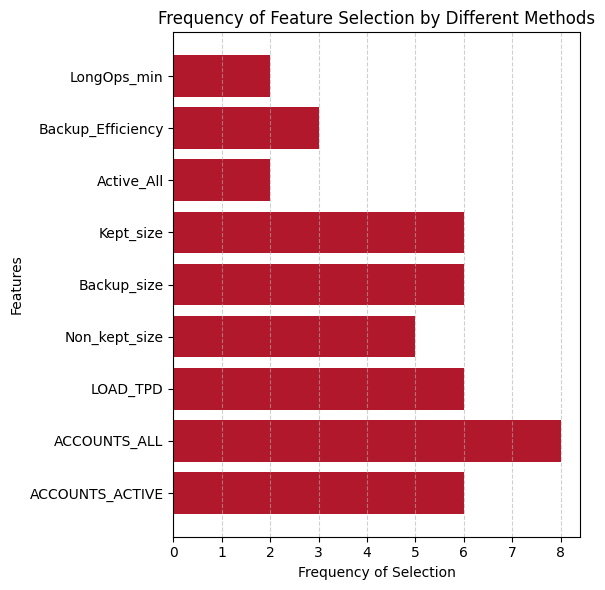

In [312]:
df = pd.DataFrame(data_num_ch)
plt.figure(figsize=(6, 6))
plt.barh(df['Feature'], df['Selected'])
plt.xlabel('Frequency of Selection')
plt.ylabel('Features')
plt.title('Frequency of Feature Selection by Different Methods')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Variance Inflation Factor (VIF):

Calculate VIF scores for each feature to assess the degree of multicollinearity. High VIF scores (typically above 5 or 10) indicate strong multicollinearity and may suggest dropping one of the correlated features.

In [317]:
X = data_norm_stand.drop('SIZE', axis=1)
# X = X.drop('ACCOUNTS_ALL', axis=1)
# X = X.drop('Kept_size', axis=1)
# X = X.drop('Active_All', axis=1)
# X = X.drop('Non_kept_size', axis=1)
# X = X.drop('Backup_Efficiency', axis=1)
# X = X.drop('ACCOUNTS_ACTIVE', axis=1)
vif_data = X.assign(const=1) 
vif_series = pd.Series([variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])], index=vif_data.columns)
pd.options.display.float_format = '{:.2f}'.format
vif_series

LOAD_TPD               48.63
ACCOUNTS_ALL        28764.48
ACCOUNTS_ACTIVE     25290.57
Non_kept_size        1101.61
Backup_size          6065.83
LongOps_min            11.17
Active_All             49.02
Backup_Efficiency    2041.49
Kept_size           21340.01
const                   1.00
dtype: float64

In [314]:
X = data_norm_stand.drop('SIZE', axis=1)
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(X) 
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
principal_components = pca.components_
singular_values = pca.singular_values_
feature_names = X.columns

print("Explained Variance:", explained_variance)
print("Explained Variance Ratio:", explained_variance_ratio)
print("Principal Components:", principal_components)
print("Singular Values:", singular_values)
principal_features = pd.DataFrame(principal_components, columns=feature_names)
print(principal_features)

Explained Variance: [7.42944656 1.30555089]
Explained Variance Ratio: [0.80898418 0.14215999]
Principal Components: [[ 0.3592086   0.36568725  0.3665476  -0.20349049  0.2901486  -0.34627587
   0.32284741 -0.34638273  0.3649272 ]
 [ 0.04574803  0.12114132  0.11162262  0.73621422  0.54421942  0.17419193
   0.01110362  0.29134674  0.13129012]]
Singular Values: [19.07990779  7.9982494 ]
   LOAD_TPD  ACCOUNTS_ALL  ACCOUNTS_ACTIVE  Non_kept_size  Backup_size  \
0      0.36          0.37             0.37          -0.20         0.29   
1      0.05          0.12             0.11           0.74         0.54   

   LongOps_min  Active_All  Backup_Efficiency  Kept_size  
0        -0.35        0.32              -0.35       0.36  
1         0.17        0.01               0.29       0.13  
